In [1]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import modules
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from haversine import haversine
import copy
import numpy as np

In [3]:
# import dataset
path = '/content/drive/MyDrive/Algorithm/Genetic_algorithm_project_data/'
os.listdir(path)
cities_pd_dict = {}
for i in os.listdir(path):
  tmp_pd  = pd.read_csv(path+i)
  cities_pd_dict[i.split('.')[0]] = tmp_pd
print(list(cities_pd_dict.keys()))

['Boston', 'Denver', 'New_York', 'Philadelphia', 'Atlanta', 'Cincinnati', 'San_Francisco']


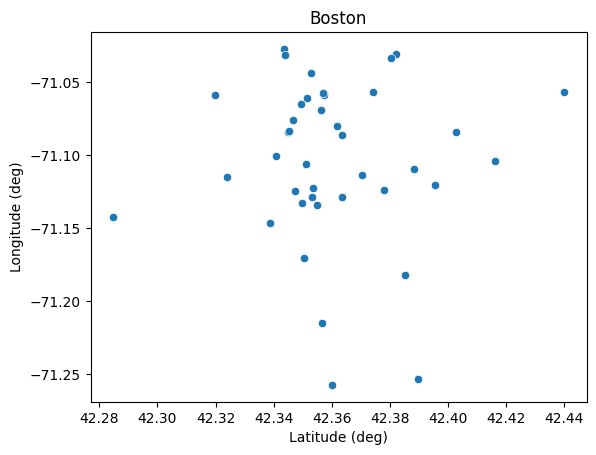

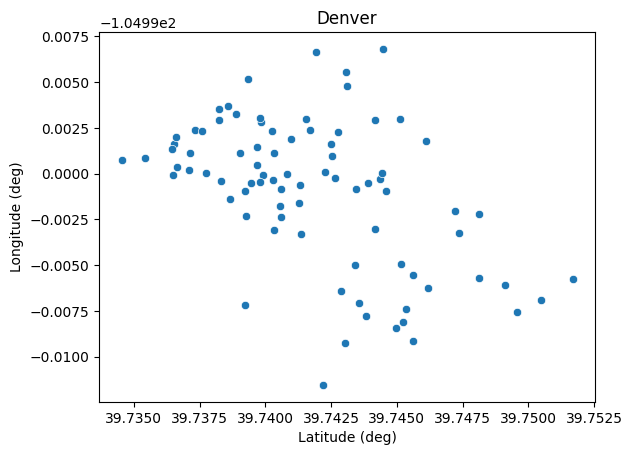

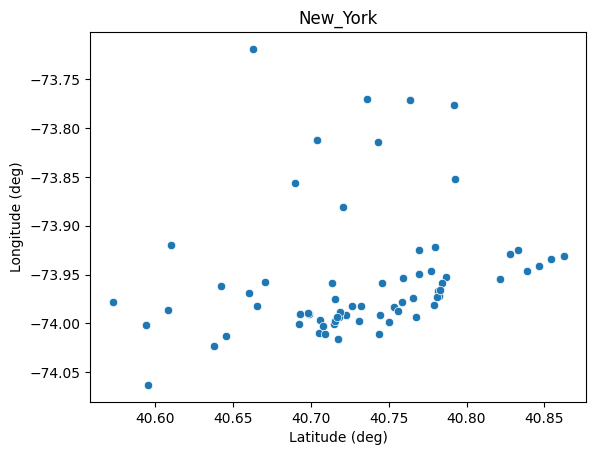

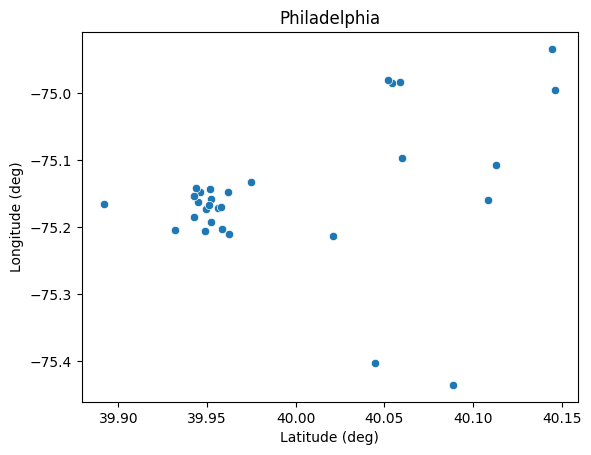

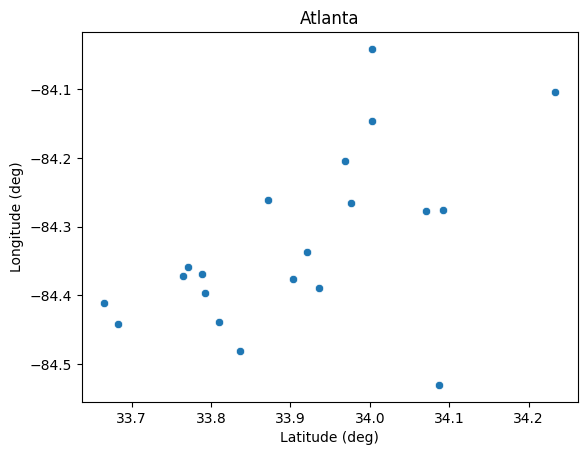

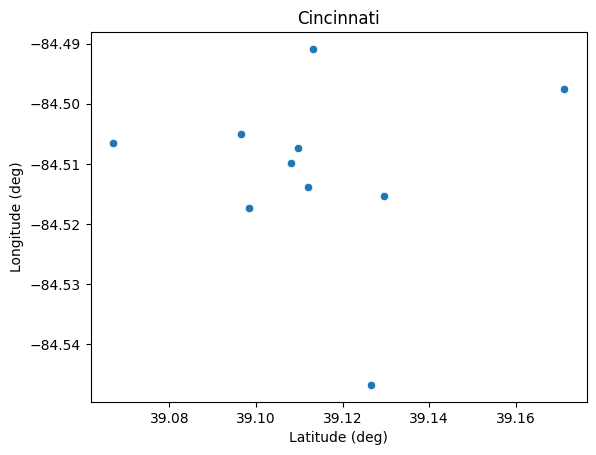

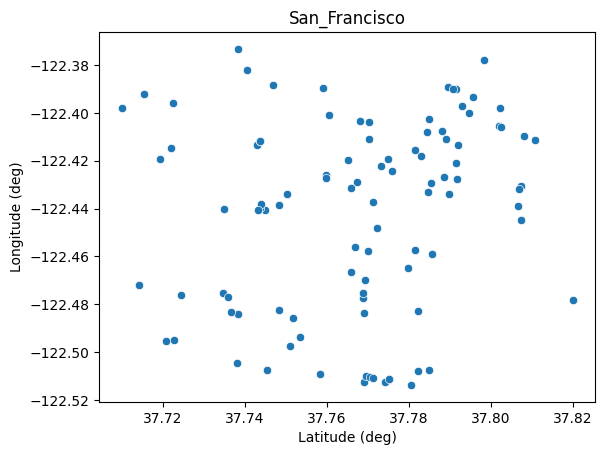

In [4]:
# visualize data points
for i in cities_pd_dict.keys():
  plt.title(i)
  sns.scatterplot(cities_pd_dict[i],x='Latitude (deg)',y='Longitude (deg)')
  plt.show()

In [5]:
################################################################################
## Utilities
# https://stricky.tistory.com/284
def generate_distance_matrix(df):
  matrix = []
  for i in range(len(df)):
    tmp = []
    for j in range(len(df)):
      harversine = haversine((df.iloc[i,1],df.iloc[i,2]),
                             (df.iloc[j,1],df.iloc[j,2]), unit = 'm')
      tmp.append(harversine)
    matrix.append(tmp)
  return matrix

# Written by Jimin Kim
def total_distance(list,city):
    atlanta = cities_pd_dict[city]
    total = 0
    for i in range(len(list)-1):
        distance = haversine((atlanta.iloc[list[i],1], atlanta.iloc[list[i],2]), 
                             (atlanta.iloc[list[i+1],1],atlanta.iloc[list[i+1],2]), unit = 'm')
        total += distance
    return total

# list data to dictionary contained fitness and distance
def list_to_dict(pop_list, distances, city):
  dist_list = [total_distance(p,city) for p in pop_list]
  fit_list = [calculate_fitness(p,distances) for p in pop_list]
  pop_dict = {}
  for i in range(len(pop_list)):
    pop_dict[fit_list[i]] = {'gene':pop_list[i],
                             'distance':dist_list[i],
                             'fitness':fit_list[i]}
  return pop_dict

def num_of_unique(log):
  bits_list = [log_[-1][i]['gene'] for i in log_[-1].keys()]
  bits_slist = []
  for i in bits_list:
    tmp = ''
    for j in i:
      tmp+=str(j)
    bits_slist.append(tmp)
  print('Number of unique popluation:',len(set(bits_slist)))

# https://www.geeksforgeeks.org/python-find-closest-number-to-k-in-given-list/
def closest(lst, K):     
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx


################################################################################
# Written by ChatGPT
# Define a function to calculate the fitness of a chromosome
def calculate_fitness(chromosome,distances):
    distance = 0
    for i in range(len(chromosome) - 1):
        distance += distances[chromosome[i]][chromosome[i+1]]
    distance += distances[chromosome[-1]][chromosome[0]] # add distance from last city to first city
    return (1 / distance)**2

## Genetic Algorithm
# Written by ChatGPT
# Define a function to generate an initial population using the greedy algorithm
def minimum_with_greedy(distances):
    population = []
    start_city = 0
    unvisited_cities = set(range(len(distances)))
    chromosome = [start_city]
    current_city = start_city
    while unvisited_cities:
        next_city = min(unvisited_cities, key=lambda city: distances[current_city][city])
        unvisited_cities.remove(next_city)
        chromosome.append(next_city)
        current_city = next_city
    chromosome.append(start_city)
    population.append(chromosome[1:])
    return population[0]


In [6]:
## Selection
# input data. {fitness_value:{bit-string:_,x:_,y:_,y_with_penalty:_}}
# roulette wheel selection
def roulette_selection(pop_w_evaled_dict, num_of_parents):
  sum_ = sum(list(pop_w_evaled_dict.keys()))
  selected_pop = {}
  # make a roulette wheel
  fitness_stacked = []
  tmp = 0
  for i in pop_w_evaled_dict.keys():
    fitness_stacked.append(i+tmp)
    tmp+=i
  # Selection
  fit_values = list(pop_w_evaled_dict.keys())
  while len(selected_pop) < num_of_parents:
    selected = np.random.randint(1, sum_+1, 1)[0]
    closest_idx = closest(fitness_stacked, selected)
    if fit_values[closest_idx] not in selected_pop.keys():
      selected_pop[fit_values[closest_idx]] = pop_w_evaled_dict[fit_values[closest_idx]]
  return selected_pop
# tournament selection
def tournament_selection(pop_w_evaled_dict, K, num_of_parents):
  selected_pop = {}
  while len(selected_pop) < num_of_parents:
    selected = random.sample(pop_w_evaled_dict.keys(), K)
    if max(selected) not in selected_pop.keys():
      selected_pop[max(selected)] = pop_w_evaled_dict[max(selected)]
  return selected_pop
# Ranking-based selection
def ranking_selection(pop_w_evaled_dict, num_of_parents):
  fit_values = list(pop_w_evaled_dict.keys())
  fit_values.sort()
  selected_pop = {}
  for key in fit_values[-num_of_parents:]:
    selected_pop[key] = pop_w_evaled_dict[key]
  return selected_pop

In [21]:
## Crossover
# https://github.com/emre-kocyigit/genetic_algorithm_tsp/blob/main/GeneticAlgorithm.py
def crossover(p_1,p_2):
  one_point = random.randint(2, len(popluation[0])-1)

  child_1 = p_1[1:one_point]
  child_2 = p_2[1:one_point]

  child_1_remain = [item for item in p_2[1:-1] if item not in child_1]
  child_2_remain = [item for item in p_1[1:-1] if item not in child_2]

  child_1 += child_1_remain
  child_2 += child_2_remain

  child_1.insert(0, p_1[0])
  child_1.append(p_1[0])

  child_2.insert(0, p_2[0])
  child_2.append(p_2[0])
  return child_1, child_1

# https://github.com/emre-kocyigit/genetic_algorithm_tsp/blob/main/GeneticAlgorithm.py
# 3 Mixed two points crossover
def crossover_mix(p_1, p_2):
    point_1, point_2 = random.sample(range(1, len(p_1)-1), 2)
    begin = min(point_1, point_2)
    end = max(point_1, point_2)

    child_1_1 = p_1[:begin]
    child_1_2 = p_1[end:]
    child_1 = child_1_1 + child_1_2
    child_2 = p_2[begin:end+1]

    child_1_remain = [item for item in p_2[1:-1] if item not in child_1]
    child_2_remain = [item for item in p_1[1:-1] if item not in child_2]

    child_1 = child_1_1 + child_1_remain + child_1_2
    child_2 += child_2_remain

    child_2.insert(0, p_2[0])
    child_2.append(p_2[0])

    return child_1, child_2


# Crossover for parent popluations
def crossover_for_all(parents_pop):
  parents_key_list = list(parents_pop.keys())
  children_bit_list = []
  while len(parents_key_list)>0:
    # Choose two parents
    parents = random.sample(parents_key_list, 2)
    # Crossover
    child1, child2 = crossover_mix(parents_pop[parents[0]]['gene'],
                              parents_pop[parents[1]]['gene'])
    children_bit_list.append(child1)
    children_bit_list.append(child2)
    parents_key_list.remove(parents[0])
    parents_key_list.remove(parents[1])
  return children_bit_list


## Survived popluations
# Random
def survived_with_random(pop_w_evaled_dict, num_for_select):
  keys = list(pop_w_evaled_dict.keys())
  selected_keys = random.sample(keys,num_for_select)
  new_pops = [pop_w_evaled_dict[key]['gene'] for key in selected_keys]
  return new_pops
# Elitism
def survived_with_elitism(pop_w_evaled_dict, num_for_select):
  new_pops = []
  keys = list(pop_w_evaled_dict.keys())
  keys.sort()
  new_pops = [pop_w_evaled_dict[key]['gene'] for key in keys[-num_for_select:]]
  return new_pops

## Mutation
def do_mutation(pops, mutation_rate):
  new_pops = []
  for pop in pops:
    r = random.randint(0, 100) / 100
    if r <= mutation_rate:
      # mutation point 1
      m1_idx = random.choice(range(2,len(pop)-1))
      # mutation point 2
      while True:
        m2_idx = random.choice(range(2,len(pop)-1))
        if m1_idx!=m2_idx:
          break
      m1_val = pop[m1_idx]
      m2_val = pop[m2_idx]
      pop[m1_idx] = m2_val
      pop[m2_idx] = m1_val
    new_pops.append(pop)
  return new_pops


def print_best_(log_,n_iter):
  print("Iteration number:",n_iter)
  #print("Variance of X values:",var)
  fit_lists = list(log_[-1].keys())
  fit_lists.sort()
  optimal = log_[-1][fit_lists[-1]]
  print("Optimal solution")
  print("distance:",optimal['distance'])
  print("fitness score:", optimal['fitness'])
  print("Sequence:", optimal['gene'])
  return optimal

In [24]:
# Define the parameters for the genetic algorithm
city_name = 'Atlanta'
population_size = 200
mutation_rate = 0.1
num_generations = 100
cross_over_rate = 0.6
num_of_selected_parents = int(population_size * cross_over_rate)
num_of_preserve = population_size - num_of_selected_parents

K = 5

In [59]:
# Generate distance matrix
matrix = generate_distance_matrix(cities_pd_dict[city_name])
distances = copy.deepcopy(matrix)

## initial generation
# greedy algorithm output 
greedy_pop = minimum_with_greedy(distances)
print("Greedy algorithm ouput:",greedy_pop)
# remaining part will filled with randomly ordered popluation
popluation = []
while len(popluation) < population_size-1:
  city_index = list(range(1,len(distances)))
  tmp = [0]
  random.shuffle(city_index)
  tmp.extend(city_index)
  tmp.append(0)
  if tmp not in popluation:
    popluation.append(tmp)
popluation.append(greedy_pop)
print("Number of initial generation:",len(popluation))

Greedy algorithm ouput: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of initial generation: 100


In [60]:
popluation_dict = list_to_dict(popluation,distances,city_name)
log_ = [popluation_dict]
num_of_unique(log_)
n_iter = 0
print_best_(log_,n_iter)
print("="*20)

for i in range(num_generations):
  # selection
  parents_pop = tournament_selection(log_[n_iter],K ,num_of_selected_parents) # or roulette_selection, ranking_selection, tournament_selection
  # generate children from parents
  cross_overed = crossover_for_all(parents_pop)
  # preserved popluation in the geneartion
  preserved = survived_with_elitism(log_[n_iter], num_of_preserve) # or survived_with_random
  ## New generation
  next_generation = cross_overed + preserved
  ## Mutation 
  next_generation_w_mutated = do_mutation(next_generation,mutation_rate)

  ## Evaluation
  ng_w_dict = list_to_dict(next_generation_w_mutated, distances, city_name)
  log_.append(ng_w_dict)
  num_of_unique(log_)
  n_iter += 1
  best_path = print_best_(log_,n_iter)
  print("="*20)

Number of unique popluation: 100
Iteration number: 0
Optimal solution
distance: 101809.17400650194
fitness score: 9.647752908131808e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]


<ipython-input-6-fff689287431>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected = random.sample(pop_w_evaled_dict.keys(), K)


Number of unique popluation: 98
Iteration number: 1
Optimal solution
distance: 101809.17400650194
fitness score: 9.647752908131808e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 99
Iteration number: 2
Optimal solution
distance: 101809.17400650194
fitness score: 9.647752908131808e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 100
Iteration number: 3
Optimal solution
distance: 101809.17400650194
fitness score: 9.647752908131808e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 100
Iteration number: 4
Optimal solution
distance: 107515.7919441807
fitn

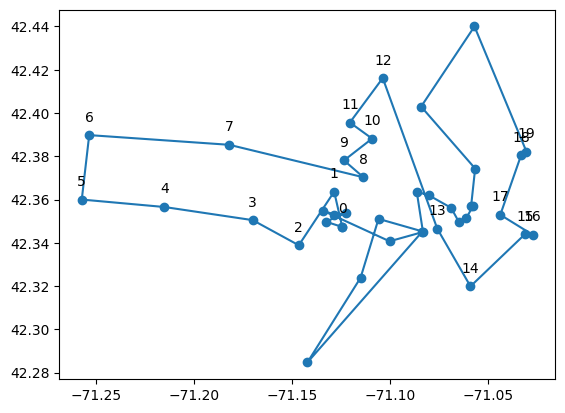

In [61]:
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(20)]
plt.plot(x[best_path['gene']], y[best_path['gene']], '-o')
for i, label in zip(best_path['gene'], labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

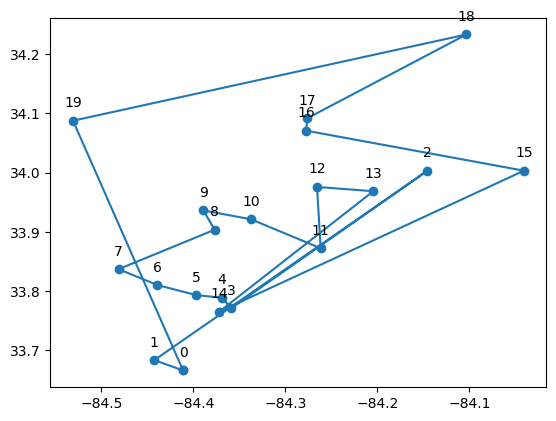

In [30]:
greedy_pop
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(20)]
plt.plot(x[greedy_pop], y[greedy_pop], '-o')
for i, label in zip(greedy_pop, labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

#San_Francisco

In [45]:
# Define the parameters for the genetic algorithm
city_name = 'Cincinnati'
population_size = 100
mutation_rate = 0.2
num_generations = 50
cross_over_rate = 0.6
num_of_selected_parents = int(population_size * cross_over_rate)
num_of_preserve = population_size - num_of_selected_parents

K = 4

In [46]:
# Generate distance matrix
matrix = generate_distance_matrix(cities_pd_dict[city_name])
distances = copy.deepcopy(matrix)

## initial generation
# greedy algorithm output 
greedy_pop = minimum_with_greedy(distances)
print("Greedy algorithm ouput:",greedy_pop)
# remaining part will filled with randomly ordered popluation
popluation = []
while len(popluation) < population_size-1:
  city_index = list(range(1,len(distances)))
  tmp = [0]
  random.shuffle(city_index)
  tmp.extend(city_index)
  tmp.append(0)
  if tmp not in popluation:
    popluation.append(tmp)
popluation.append(greedy_pop)
print("Number of initial generation:",len(popluation))

Greedy algorithm ouput: [0, 2, 1, 8, 4, 5, 7, 6, 3, 9, 0]
Number of initial generation: 100


In [47]:
popluation_dict = list_to_dict(popluation,distances,city_name)
log_ = [popluation_dict]
num_of_unique(log_)
n_iter = 0
print_best_(log_,n_iter)
print("="*20)

for i in range(num_generations):
  # selection
  parents_pop = tournament_selection(log_[n_iter],K ,num_of_selected_parents) # or roulette_selection, ranking_selection, tournament_selection
  # generate children from parents
  cross_overed = crossover_for_all(parents_pop)
  # preserved popluation in the geneartion
  preserved = survived_with_elitism(log_[n_iter], num_of_preserve) # or survived_with_random
  ## New generation
  next_generation = cross_overed + preserved
  ## Mutation 
  next_generation_w_mutated = do_mutation(next_generation,mutation_rate)

  ## Evaluation
  ng_w_dict = list_to_dict(next_generation_w_mutated, distances, city_name)
  log_.append(ng_w_dict)
  num_of_unique(log_)
  n_iter += 1
  best_path = print_best_(log_,n_iter)
  print("="*20)

Number of unique popluation: 100
Iteration number: 0
Optimal solution
distance: 30124.382281833194
fitness score: 1.1019545934497223e-09
Sequence: [0, 9, 6, 4, 3, 5, 7, 8, 1, 2, 0]
Number of unique popluation: 94
Iteration number: 1
Optimal solution
distance: 30124.382281833194
fitness score: 1.1019545934497223e-09
Sequence: [0, 9, 6, 4, 3, 5, 7, 8, 1, 2, 0]
Number of unique popluation: 94
Iteration number: 2
Optimal solution
distance: 30124.382281833194
fitness score: 1.1019545934497223e-09
Sequence: [0, 9, 6, 4, 3, 5, 7, 8, 1, 2, 0]


<ipython-input-6-fff689287431>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected = random.sample(pop_w_evaled_dict.keys(), K)


Number of unique popluation: 90
Iteration number: 3
Optimal solution
distance: 30124.382281833194
fitness score: 1.1019545934497223e-09
Sequence: [0, 9, 6, 4, 3, 5, 7, 8, 1, 2, 0]
Number of unique popluation: 92
Iteration number: 4
Optimal solution
distance: 30013.83733011601
fitness score: 1.1100868324136987e-09
Sequence: [0, 9, 6, 8, 4, 7, 3, 5, 1, 2, 0]
Number of unique popluation: 94
Iteration number: 5
Optimal solution
distance: 29528.181439316475
fitness score: 1.1469027615894012e-09
Sequence: [0, 9, 6, 3, 5, 7, 8, 4, 1, 2, 0]
Number of unique popluation: 91
Iteration number: 6
Optimal solution
distance: 29317.734149932086
fitness score: 1.163427152275552e-09
Sequence: [0, 1, 4, 8, 5, 3, 7, 6, 9, 2, 0]
Number of unique popluation: 92
Iteration number: 7
Optimal solution
distance: 29301.409367334672
fitness score: 1.1647238807584371e-09
Sequence: [0, 9, 2, 6, 3, 5, 7, 8, 4, 1, 0]
Number of unique popluation: 93
Iteration number: 8
Optimal solution
distance: 29290.342485496036
fitn

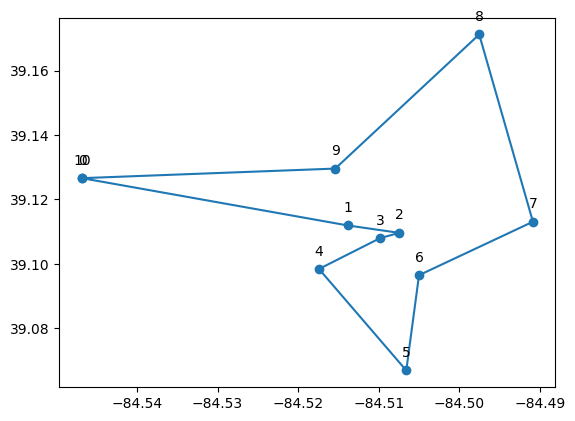

In [49]:
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(20)]
plt.plot(x[best_path['gene']], y[best_path['gene']], '-o')
for i, label in zip(best_path['gene'], labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

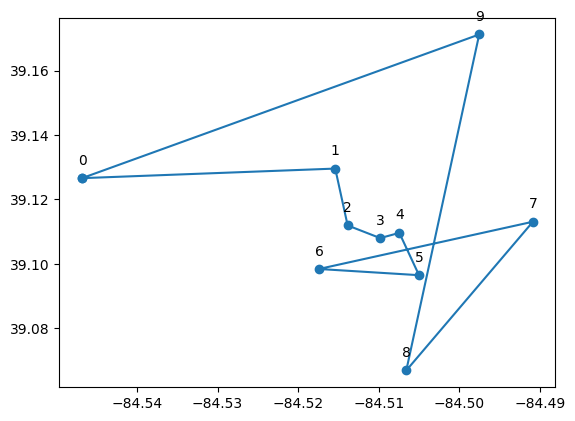

In [48]:
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(len(x))]
plt.plot(x[greedy_pop], y[greedy_pop], '-o')
for i, label in zip(greedy_pop, labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

#Boston

In [55]:
# Define the parameters for the genetic algorithm
city_name = 'Boston'
population_size = 100
mutation_rate = 0.2
num_generations = 100
cross_over_rate = 0.6
num_of_selected_parents = int(population_size * cross_over_rate)
num_of_preserve = population_size - num_of_selected_parents

K = 4

In [56]:
# Generate distance matrix
matrix = generate_distance_matrix(cities_pd_dict[city_name])
distances = copy.deepcopy(matrix)

## initial generation
# greedy algorithm output 
greedy_pop = minimum_with_greedy(distances)
print("Greedy algorithm ouput:",greedy_pop)
# remaining part will filled with randomly ordered popluation
popluation = []
while len(popluation) < population_size-1:
  city_index = list(range(1,len(distances)))
  tmp = [0]
  random.shuffle(city_index)
  tmp.extend(city_index)
  tmp.append(0)
  if tmp not in popluation:
    popluation.append(tmp)
popluation.append(greedy_pop)
print("Number of initial generation:",len(popluation))

Greedy algorithm ouput: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of initial generation: 100


In [57]:
popluation_dict = list_to_dict(popluation,distances,city_name)
log_ = [popluation_dict]
num_of_unique(log_)
n_iter = 0
print_best_(log_,n_iter)
print("="*20)

for i in range(num_generations):
  # selection
  parents_pop = tournament_selection(log_[n_iter],K ,num_of_selected_parents) # or roulette_selection, ranking_selection, tournament_selection
  # generate children from parents
  cross_overed = crossover_for_all(parents_pop)
  # preserved popluation in the geneartion
  preserved = survived_with_elitism(log_[n_iter], num_of_preserve) # or survived_with_random
  ## New generation
  next_generation = cross_overed + preserved
  ## Mutation 
  next_generation_w_mutated = do_mutation(next_generation,mutation_rate)

  ## Evaluation
  ng_w_dict = list_to_dict(next_generation_w_mutated, distances, city_name)
  log_.append(ng_w_dict)
  num_of_unique(log_)
  n_iter += 1
  best_path = print_best_(log_,n_iter)
  print("="*20)

Number of unique popluation: 100
Iteration number: 0
Optimal solution
distance: 101809.17400650194
fitness score: 9.647752908131808e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 28, 22, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]


<ipython-input-6-fff689287431>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected = random.sample(pop_w_evaled_dict.keys(), K)


Number of unique popluation: 98
Iteration number: 1
Optimal solution
distance: 103799.17153690179
fitness score: 9.28137297967437e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 27, 12, 37, 22, 35, 28, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 100
Iteration number: 2
Optimal solution
distance: 106905.01148452089
fitness score: 8.749915742299306e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 27, 12, 22, 38, 28, 30, 24, 37, 35, 6, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 100
Iteration number: 3
Optimal solution
distance: 109337.63591854776
fitness score: 8.364897837380618e-11
Sequence: [0, 9, 20, 10, 34, 1, 17, 26, 39, 18, 3, 21, 19, 29, 36, 38, 24, 30, 6, 12, 37, 22, 35, 28, 27, 5, 7, 14, 16, 13, 2, 15, 8, 33, 32, 11, 25, 31, 4, 23, 0]
Number of unique popluation: 99
Iteration number: 4
Optimal solution
distance: 109337.63591854776
fitn

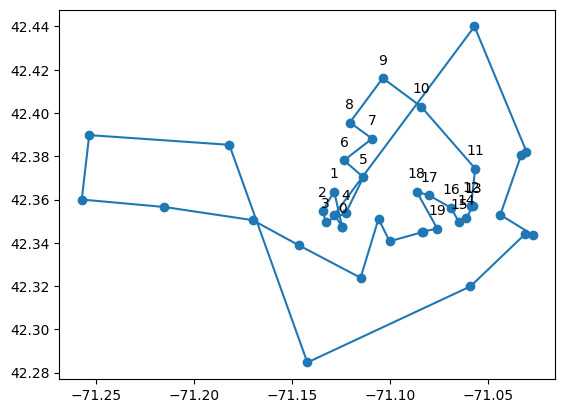

In [58]:
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(20)]
plt.plot(x[best_path['gene']], y[best_path['gene']], '-o')
for i, label in zip(best_path['gene'], labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

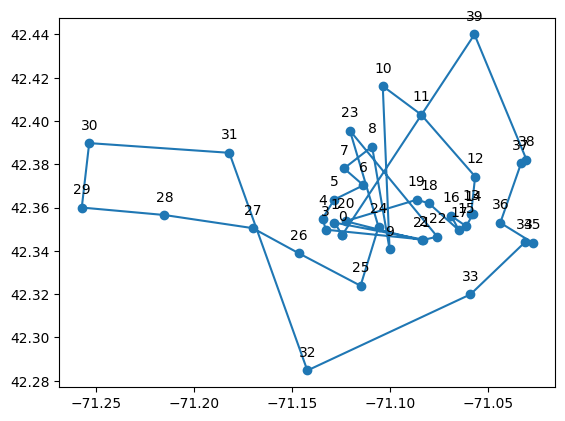

In [54]:
x = cities_pd_dict[city_name]['Longitude (deg)'].values
y = cities_pd_dict[city_name]['Latitude (deg)'].values
labels = [x for x in range(len(x))]
plt.plot(x[greedy_pop], y[greedy_pop], '-o')
for i, label in zip(greedy_pop, labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()